In [1]:
!pip install transformers dateparser


In [6]:
import re
from transformers import pipeline
import dateparser
import pandas as pd
import matplotlib.pyplot as plt


#  NER Pipeline
# # Use a Hugging Face model which is fine-tuned for Named Entity Recognition.
ner = pipeline("ner", model="Jean-Baptiste/camembert-ner-with-dates", aggregation_strategy="simple")

# ner = pipeline("ner", model="dslim/bert-base-NER")#, aggregation_strategy="simple")

config.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Device set to use cuda:0


In [7]:


# input text
financial_text = """
On Jan 4, 2024, Global Markets Inc. reported an unprecedented surge in trading volumes.
Later, on 04/05/2024, the company announced plans to launch a new trading platform.
Subsequently, on March 10th, 2024, additional data revealed that the market volatility had increased.
Finally, on 2024-04-15, analysts confirmed that the growth trajectory was sustained.
"""


In [8]:

#  Extract DATE Entities Using NER
results = ner(financial_text)

# Filter for entities that are recognized as DATE.
date_entities = [
    result for result in results
    if ("DATE" in (result.get("entity_group") or result.get("entity") or "").upper())
]

print("DATE Entities in the text to see")
for ent in date_entities:
    print(ent)

#Standardize Dates
def standardize_date(date_str):

    parsed_date = dateparser.parse(date_str)
    if parsed_date:
        return parsed_date.strftime("%Y-%m-%d")
    else:
        return date_str

DATE Entities in the text to see
{'entity_group': 'DATE', 'score': 0.99351245, 'word': 'Jan 4, 2024', 'start': 3, 'end': 15}
{'entity_group': 'DATE', 'score': 0.97820413, 'word': '04/05/2024', 'start': 99, 'end': 110}
{'entity_group': 'DATE', 'score': 0.9931452, 'word': 'March 10th, 2024', 'start': 191, 'end': 208}
{'entity_group': 'DATE', 'score': 0.9870515, 'word': '2024-04-15', 'start': 289, 'end': 300}


In [9]:
print(results)

[{'entity_group': 'DATE', 'score': 0.99351245, 'word': 'Jan 4, 2024', 'start': 3, 'end': 15}, {'entity_group': 'ORG', 'score': 0.97775173, 'word': 'Global Markets Inc.', 'start': 16, 'end': 36}, {'entity_group': 'DATE', 'score': 0.97820413, 'word': '04/05/2024', 'start': 99, 'end': 110}, {'entity_group': 'DATE', 'score': 0.9931452, 'word': 'March 10th, 2024', 'start': 191, 'end': 208}, {'entity_group': 'DATE', 'score': 0.9870515, 'word': '2024-04-15', 'start': 289, 'end': 300}]


In [10]:


# map  original date strings to standardized dates.
standardized_dates = {}
for ent in date_entities:
    # check with word
    original = ent['word']
    std_date = standardize_date(original)
    standardized_dates[original] = std_date

print("Standardized Dates:")
for orig, std in standardized_dates.items():
    print(f"{orig} -> {std}")

#Replace Dates in the Original Text
def replace_dates(text, standardized_dates):

    # Replaces of date  in the text with standardized dates.

    for original, std in standardized_dates.items():
        # get a regex pattern
        pattern = r'\b' + re.escape(original) + r'\b'
        text = re.sub(pattern, std, text)
    return text

standardized_text = replace_dates(financial_text, standardized_dates)
print("\nStandardized  Text with standardised dates")
print(standardized_text)

Standardized Dates:
Jan 4, 2024 -> 2024-01-04
04/05/2024 -> 2024-04-05
March 10th, 2024 -> 2024-03-10
2024-04-15 -> 2024-04-15

Standardized  Text with standardised dates

On 2024-01-04, Global Markets Inc. reported an unprecedented surge in trading volumes. 
Later, on 2024-04-05, the company announced plans to launch a new trading platform. 
Subsequently, on 2024-03-10, additional data revealed that the market volatility had increased. 
Finally, on 2024-04-15, analysts confirmed that the growth trajectory was sustained.




Assume that the standardized dates serve as the time index for historical data.   In real-world applications, consistent date formats allow for proper alignment and ordering of historical data for fin data

In [11]:
unique_std_dates = list(set(standardized_dates.values()))
print(unique_std_dates)

['2024-04-05', '2024-01-04', '2024-03-10', '2024-04-15']


            Value
Date             
2024-01-04    100
2024-03-10    105
2024-04-05    110
2024-04-15    115


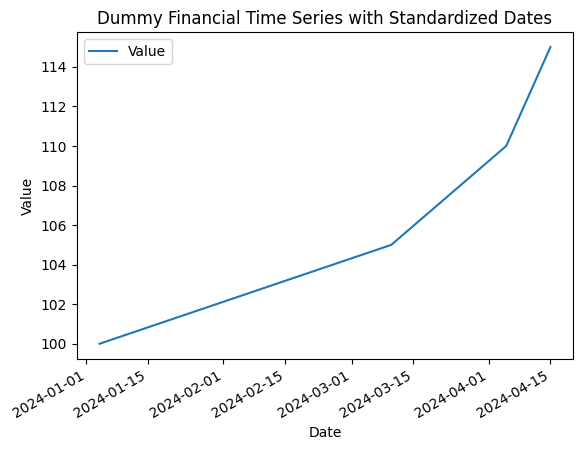

In [12]:
#  Time-Series Forecasting. Get unique date values.
unique_std_dates = list(set(standardized_dates.values()))
# sort
unique_dates = sorted([dateparser.parse(d) for d in unique_std_dates if dateparser.parse(d)])

# sample dta
df = pd.DataFrame({
    "Date": unique_dates,
    "Value": [100 + i * 5 for i in range(len(unique_dates))]
})
df.set_index("Date", inplace=True)
print(df)

# Plot the time series.
df.plot(kind="line", title="Dummy Financial Time Series with Standardized Dates")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()
